## Exercise

Load the national COVID dataset and solve the exercise using `scikit-learn` library.
Consider first the column corresponding to the (cumulative) number of deaths. 
1. Perform a train-test split, with observations from the last week corresponding to the test set;
2. Build a suitable combination of kernels choosing from the ones shown in `notebook_05`;
3. Fit a `GaussianProcessRegressor` to predict the daily number of swabs, plot future predictions and compare them to real test data;
4. Repeat points 1-3 on the daily number of swabs, which can be computed from the cumulative number provided in the dataset.

You are welcome to try out and fit other data streams in the dataset. 


In [8]:
import numpy as np
from sklearn import gaussian_process
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mt
import os
import pandas as pd
import datetime as dt

mt.rcParams['axes.titlesize'] = 20
mt.rcParams['axes.labelsize'] = 16
mt.rcParams['xtick.labelsize'] = 12
mt.rcParams['ytick.labelsize'] = 12
mt.rcParams['legend.fontsize'] = 14

1. **Solution**

    I load the dataset from `data` folder and I set the `date` as the index of the dataframe

In [9]:
# Load the monthly dataset
data_covid = pd.read_csv("data/COVID_national_20200421.csv")

# fix column names
cols = list(data_covid.columns[data_covid.columns != 'Unnamed: 0'])
data_covid = data_covid[cols]

# drop rows with nan
data_covid.dropna(inplace=True)

# set date as index
data_covid['date'] = pd.to_datetime(data_covid['date'])
data_covid = data_covid.set_index('date', drop=True)


data_covid.head()

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined
date,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94
2020-02-25,10,8623,35,114,93,322,1,162
2020-02-26,12,9587,36,128,78,400,3,221
2020-02-27,17,12014,56,248,250,650,45,284
2020-02-28,21,15695,64,345,238,888,46,412


In [10]:
# Helpful functions

def dates_to_idx(timelist):
    reference_time = pd.to_datetime('2020-02-24')
    t = (timelist - reference_time) / pd.Timedelta(1, "D")
    return np.asarray(t)

def idx_to_date(time_index):
    reference_time = pd.to_datetime('2020-02-24')
    date=[[reference_time+pd.Timedelta(time_index[i], "D")] for i in range(len(time_index))]
    return np.array(date)



Since our analysis is focused on daily swabs analysis, inside the `data_covid` dataframe I add two columns:

   * `t`: which represents the number of day after the first day, that was the 24-02-2020.

* `daily_swabs`: which represents the number of daily swabs; it is simply computed by subracting the current number of swabs with the previous one.


In [11]:
t = dates_to_idx(data_covid.index)

# log-scale
y = data_covid["swabs"].values
daily_swabs = [y[0] if i==0 else y[i]-y[i-1] for i in range(len(y))]
y_n = daily_swabs

data_covid = data_covid.assign(t = t)
data_covid = data_covid.assign(daily_swab = daily_swabs)


data_covid.head()

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined,t,daily_swab
date,,,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94,0.0,4324
2020-02-25,10,8623,35,114,93,322,1,162,1.0,4299
2020-02-26,12,9587,36,128,78,400,3,221,2.0,964
2020-02-27,17,12014,56,248,250,650,45,284,3.0,2427
2020-02-28,21,15695,64,345,238,888,46,412,4.0,3681


In order to make the split between **train** and **test** data, I decide to train my model with the data that comes from the dataframe till the date 2020-04-13.

I store the dataframe relative to the train set in `data train`:

In [84]:
# index relative to 2020-04-13
sep_idx = data_covid.index.searchsorted(pd.to_datetime("2020-04-13"))

#dataframe of train set
data_train = data_covid.iloc[:sep_idx+1, :]

data_train.head(3)

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined,t,daily_swab
date,,,,,,,,,,
2020-02-24,7,4324,26,101,221,229,1,94,0.0,4324
2020-02-25,10,8623,35,114,93,322,1,162,1.0,4299
2020-02-26,12,9587,36,128,78,400,3,221,2.0,964


while the dataset relatives to the days after the 13-04-2020 are stored inside `data_test`:

In [85]:
#dataframe relative to test-set
data_test = data_covid.iloc[sep_idx:, :]

data_test.head(3)

,deaths,swabs,ICU,hospitalized,new_infections,cumulative_infections,recovered,quarantined,t,daily_swab
date,,,,,,,,,,
2020-04-13,20465,1046910,3260,28023,3153,159516,35435,72333,49.0,36717
2020-04-14,21067,1073689,3186,28011,2972,162488,37130,73094,50.0,26779
2020-04-15,21645,1117404,3079,27643,2667,165155,38092,74696,51.0,43715


2. **Solution**:

Since we are interested on fitting the number of daily swabs during time, let's have a graphical view of this dataset

Text(0.5,1,'daily swabs as a function of time index')

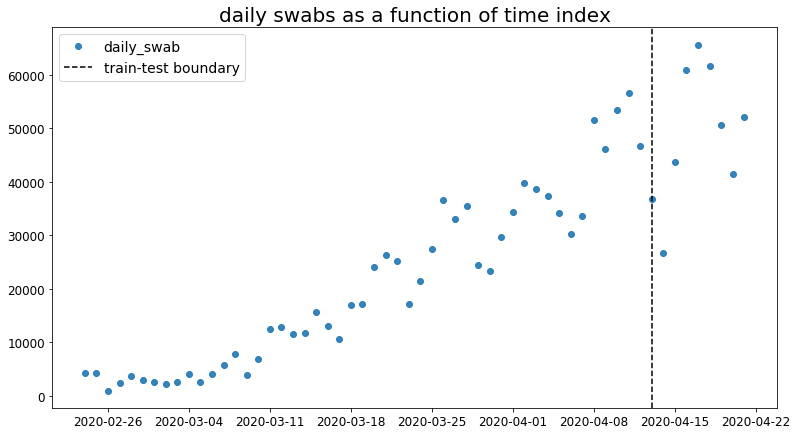

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

ax.plot(data_covid.index, data_covid.daily_swab, marker='o', linestyle='', alpha=0.9)
ax.axvline(pd.to_datetime("2020-04-13"), linestyle='--', color='k', label="train-test boundary")
ax.legend()
ax.set_title('daily swabs as a function of time index')

The daily number of swabs looks to have a linear increasing during time but with some periodic behaviour inside very brief time intervals (5~7 days). 

In order to build a suitable kernel that might fit `daily_swabs`, let's check if the data have these property of linearity and periodicity.

In order to check if linearity can be a good hypotesis, let's fit a simple linear regression just calling the ``LinearRegression`` function provided by `sklearn` library:

Text(0.5,1,'Daily swabs as a function of time index')

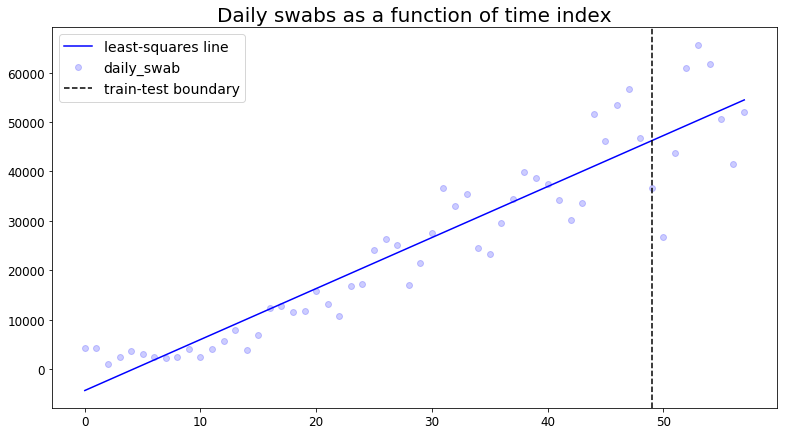

In [33]:
from sklearn.linear_model import LinearRegression

X = data_covid.t.values[:, None]
y = data_covid.daily_swab.values
train_X = X[:len(data_early)]
train_y = y[:len(data_early)]
test_X = X[len(data_early):]
test_y = y[len(data_early):]

# y = 1 * x_0 + 2 * x_1 + 3
#y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(train_X, train_y)


retta = reg.intercept_ + np.dot(X,reg.coef_)

fig, ax = plt.subplots(1, 1, figsize=(13, 7))

ax.plot(data_covid.t.values, retta, color='b', label = 'least-squares line')
ax.plot(data_covid.t.values, data_covid.daily_swab, color='b', marker='o', linestyle='', alpha=0.2)
ax.axvline(dates_to_idx(pd.to_datetime("2020-04-13")), linestyle='--', color='k', label="train-test boundary")
ax.legend()
ax.set_title('Daily swabs as a function of time index')

As we can visualize, the data seems to have this general tendency to increase linearly over time

Taking the least square line as a really raw estimate of this linear increasing, I consider the residuals from the least-square line on the daily swabs taken every Monday from 09-03-2020: 

In [69]:
data_covid.daily_swab[14:len(daily_swabs):7] - retta[14:len(daily_swabs):7]

date
2020-03-09    -6207.390588
2020-03-16    -4261.263529
2020-03-23    -7486.136471
2020-03-30    -8451.009412
2020-04-06    -8736.882353
2020-04-13    -9518.755294
2020-04-20   -11980.628235
Name: daily_swab, dtype: float64

All residuals of swabs taken every 7 days seems to have (at first order) a similar negative value. This can be explained by some periodic phenomena that seems to happen during 7 days, while the absolute number of swabs has costant increasing. 

**Thus, the daily number of swabs has a steady upward trend with a 7-days effect of periodicity** 

In [753]:
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, DotProduct, RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

In [781]:
#plot gaussian process result

def plot_predictions(gp, include_observed=True):
    pred_y, pred_std = gp.predict(X, return_std=True)
    plt.figure(figsize=(10, 5))
    x = X[:, 0]
    if include_observed:
        plt.plot(x, y, 'ok', alpha=0.1)
    l, = plt.plot(x, pred_y)
    plt.fill_between(x,
                     pred_y + pred_std,
                     pred_y - pred_std,
                     color=l.get_color(), alpha=0.3)
    if np.allclose(X[:, 0], data_covid.t.values):
        plt.axvline(dates_to_idx(pd.to_datetime("2020-04-13")), linestyle='--', color='k')
    else:
        plt.axvline(pd.to_datetime("2020-04-13"), linestyle='--', color='k')

In [782]:
X = data_covid.t.values[:, None]
y = data_covid.daily_swab.values
train_X = X[:len(data_train)]
train_y = y[:len(data_train)]
test_X = X[len(data_test):]
test_y = y[len(data_test):]

In [783]:
k1 = 316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03)

kernel =  k1

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
# Train the regressor
gp0.fit(train_X, train_y)

print("Kernel before: ", gp0.kernel)
print(" ")
print("Kernel before: ", gp0.kernel_)
print(" ")
# All other parameters of the GP
print("Parameters:", gp0.get_params())
print(" ")
# The log marginal likelihood of the MAP can be found after training
print("Marginal likelihood value: ", gp0.log_marginal_likelihood_value_)
print(" ")
# The fitted kernel's parameters are packed into an array
print("Theta: ", gp0.kernel_.theta)

Kernel before:  316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03)
 
Kernel before:  316**2 * DotProduct(sigma_0=77.7) + 90**2 * WhiteKernel(noise_level=3.56e+03)
 
Parameters: {'alpha': 0.01, 'copy_X_train': True, 'kernel__k1': 316**2 * DotProduct(sigma_0=77.7), 'kernel__k2': 86.7**2 * WhiteKernel(noise_level=6.26e+03), 'kernel__k1__k1': 316**2, 'kernel__k1__k2': DotProduct(sigma_0=77.7), 'kernel__k1__k1__constant_value': 99856, 'kernel__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k2__sigma_0': 77.7, 'kernel__k1__k2__sigma_0_bounds': (1e-05, 100000.0), 'kernel__k2__k1': 86.7**2, 'kernel__k2__k2': WhiteKernel(noise_level=6.26e+03), 'kernel__k2__k1__constant_value': 7516.89, 'kernel__k2__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k2__k2__noise_level': 6260.0, 'kernel__k2__k2__noise_level_bounds': (1e-05, 100000.0), 'kernel': 316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03), 'n_restarts_optimizer

316**2 * DotProduct(sigma_0=77.7) + 90**2 * WhiteKernel(noise_level=3.56e+03)


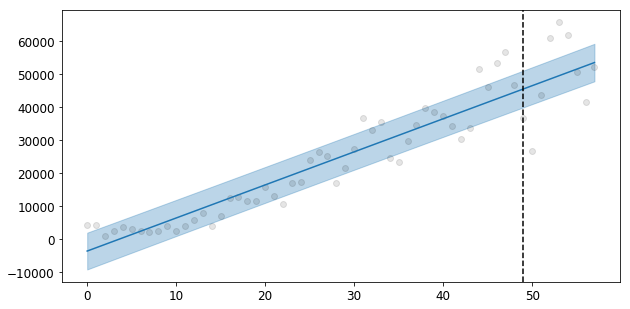

In [784]:
plot_predictions(gp0)
print(str(gp0.kernel_))

In [785]:
k1 = 316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03)
k2 = ExpSineSquared(length_scale=3.26,periodicity=7.0, periodicity_bounds="fixed")

kernel =  k1*k2

# Create the regressor
gp0 = GaussianProcessRegressor(kernel=kernel, alpha=0.01,
                               normalize_y=True,
                               n_restarts_optimizer=3)
# Train the regressor
gp0.fit(train_X, train_y)

print("Kernel before: ", gp0.kernel)
print(" ")
print("Kernel before: ", gp0.kernel_)
print(" ")
# All other parameters of the GP
print("Parameters:", gp0.get_params())
print(" ")
# The log marginal likelihood of the MAP can be found after training
print("Marginal likelihood value: ", gp0.log_marginal_likelihood_value_)
print(" ")
# The fitted kernel's parameters are packed into an array
print("Theta: ", gp0.kernel_.theta)

Kernel before:  316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03) * ExpSineSquared(length_scale=3.26, periodicity=7)
 
Kernel before:  316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03) * ExpSineSquared(length_scale=3.26, periodicity=7)
 
Parameters: {'alpha': 0.01, 'copy_X_train': True, 'kernel__k1': 316**2 * DotProduct(sigma_0=77.7) + 86.7**2 * WhiteKernel(noise_level=6.26e+03), 'kernel__k2': ExpSineSquared(length_scale=3.26, periodicity=7), 'kernel__k1__k1': 316**2 * DotProduct(sigma_0=77.7), 'kernel__k1__k2': 86.7**2 * WhiteKernel(noise_level=6.26e+03), 'kernel__k1__k1__k1': 316**2, 'kernel__k1__k1__k2': DotProduct(sigma_0=77.7), 'kernel__k1__k1__k1__constant_value': 99856, 'kernel__k1__k1__k1__constant_value_bounds': (1e-05, 100000.0), 'kernel__k1__k1__k2__sigma_0': 77.7, 'kernel__k1__k1__k2__sigma_0_bounds': (1e-05, 100000.0), 'kernel__k1__k2__k1': 86.7**2, 'kernel__k1__k2__k2': WhiteKernel(noise_level=6.26e+03), 'kernel_

316**2 * DotProduct(sigma_0=47.2) + 65.1**2 * WhiteKernel(noise_level=3.53e+03) * ExpSineSquared(length_scale=3.26, periodicity=7)


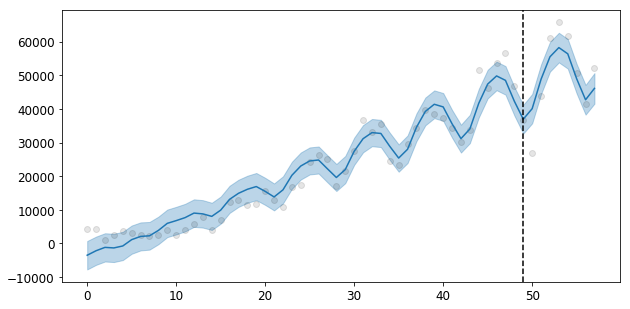

In [786]:
plot_predictions(gp0)
print(str(gp0.kernel_))

In [787]:
y_hat = (gp0.predict(X))
data_covid = data_covid.assign(y_hat = y_hat)

reference_time = pd.to_datetime("2020-02-24")
date_idx = np.array([[i] for i in range(0,80)])

date_days = [reference_time+pd.Timedelta(date_idx[i][0], "D") for i in range(80)] 

Text(0.5,1,'Daily wabs as a function of time index')

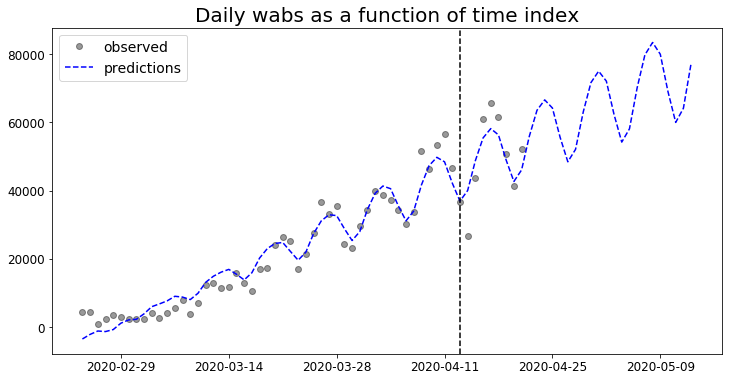

In [788]:
Y_hat = (gp0.predict(date_idx))

#data_covid = data_covid.assign(y_hat = Y_hat)


fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(date_days[0:len(data_covid.daily_swab.values)], data_covid.daily_swab.values, color='black', marker='o', linestyle='', alpha= 0.4,label='observed')
ax.plot(date_days, Y_hat, color='b', linestyle='--', label="predictions")
ax.axvline(pd.to_datetime("2020-04-13"), linestyle='--', color='k')
ax.legend()
ax.set_title('Daily wabs as a function of time index')

3. **Solution** 

4. **Solution** 

Text(0.5,1,'Cumulative number of swabs')

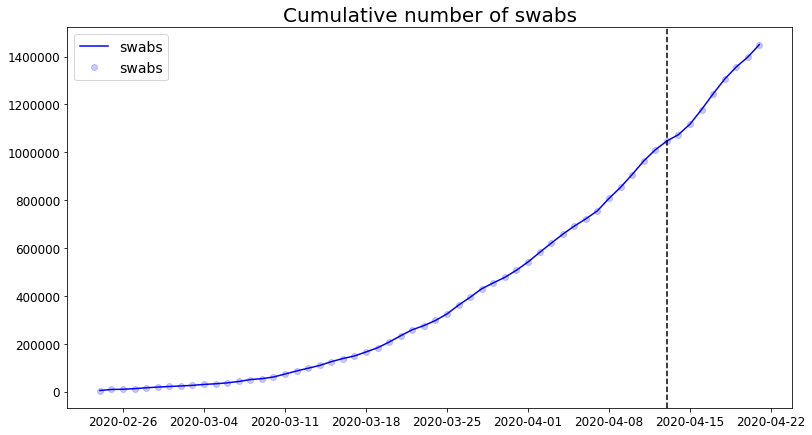

In [738]:
fig, ax = plt.subplots(1, 1, figsize=(13, 7))

ax.plot(data_covid.index.values, data_covid.swabs, color='b')
ax.plot(data_covid.index.values, data_covid.swabs, color='b', marker='o', linestyle='', alpha=0.2)
ax.axvline("2020-04-13", linestyle='--', color='k')
ax.legend()
ax.set_title('Cumulative number of swabs')